<center><font size="10">Mehta Purvil</font></center>
<br><center><font size="6">Github Username: purvilmehta06</font></center>
<br><center><font size="6">USC ID: 6104797766</font></center>

# Package imports

In [8]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
warnings.simplefilter('ignore')

# Constants

In [9]:
data_folder_path = '../data/AReM/'
columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
all_features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
all_features_names = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
classes_ = {'bending1': 0, 'bending2': 1, 'cycling': 2, 'lying': 3, 'sitting': 4, 'standing': 5, 'walking': 6}
rev_classes_ = {0: 'bending1', 1: 'bending2', 2: 'cycling', 3: 'lying', 4: 'sitting', 5: 'standing', 6: 'walking'}
binary_class_dict = {1: 'bending', 0: 'non-bending'}

# 1. Time Series Classification Part 1: Feature Creation/Extraction

## (a) Get the AReM Data Set and cleaning

In [10]:
files = {}
for folder in os.listdir(data_folder_path):
    if folder == '.DS_Store': continue
    for file in os.listdir(data_folder_path + folder):
        key = data_folder_path + folder + '/' + file
        files[key] = pd.read_csv(key, skiprows = 4, usecols = [0, 1, 2, 3, 4, 5, 6])
        del files[key][files[key].columns[0]]

## (b) Test and Train Data

In [11]:
test_data = {}
train_data = {}
for folder in os.listdir(data_folder_path):
    if folder == '.DS_Store': continue
    for file in os.listdir(data_folder_path + folder):
        file_name = data_folder_path + folder + '/' + file
        if (folder == 'bending1' or folder == 'bending2'):
            if file == 'dataset1.csv' or file == 'dataset2.csv':
                test_data[file_name] = files[file_name]
            else:
                train_data[file_name] = files[file_name]
        else:
            if file == 'dataset1.csv' or file == 'dataset2.csv' or file == 'dataset3.csv':
                test_data[file_name] = files[file_name]
            else:
                train_data[file_name] = files[file_name]

print("Total Train Dataset Files: ", len(train_data))
print("Total Test Dataset Files: ", len(test_data))

Total Train Dataset Files:  69
Total Test Dataset Files:  19


## (c) Feature Extraction

### i. Research

In time series classification, time-domain features are extracted from the raw data to capture the underlying patterns and characteristics of the time series. Some of the commonly used time-domain features in time series classification are:

* Mean: The arithmetic mean of the values in the time series.
* Standard deviation: A measure of the variability or spread of the time series values.
* Skewness: A measure of the asymmetry of the distribution of the time series values.
* Variance: A measure of the dispersion of the time series values around the mean.
* Interquartile range: The difference between the 75th and 25th percentiles of the time series values.
* Cross Correlation - Cross-correlation is another commonly used time-domain feature in time series classification. It measures the similarity between two time series by computing the correlation between them at different time lags. Cross-correlation can help identify patterns that are similar between two time series, even if they are not aligned in time. 
* Autocorrelation: Autocorrelation is a measure of the correlation between a time series and a lagged version of itself, and can help identify repeating patterns or cycles within the time series. 
* Autoregressive (AR) - These models are a type of time series model that use past values of a time series to predict future values. The order of the AR model, denoted by p, specifies how many past values of the time series are used in the model.
* Other parameters of ARIMA (Autoregressive integrated moving average) model like Integrated (I) and Moving Average (MA) are also some of the important features of any Time series data.

These are just some examples of the many time-domain features that can be used in time series classification. The specific choice of features may depend on the nature of the data and the particular classification problem at hand.

### ii. Extraction

In [12]:
cols = ['min', 'max', 'mean', 'median', 'std', '1quartile', '3quartile']
parameters = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
extract_data = []
for k, v in files.items():
    stats = files[k].describe()
    temp = {}
    for feature in list(files[k].columns):
        for parameter in parameters:
            temp[feature + '_' + parameter] = stats[feature][parameter] 
    extract_data.append(temp)
extract_data = pd.DataFrame(extract_data)
extract_data

,avg_rss12_min,avg_rss12_max,avg_rss12_mean,avg_rss12_50%,avg_rss12_std,avg_rss12_25%,avg_rss12_75%,var_rss12_min,var_rss12_max,var_rss12_mean,...,avg_rss23_std,avg_rss23_25%,avg_rss23_75%,var_rss23_min,var_rss23_max,var_rss23_mean,var_rss23_50%,var_rss23_std,var_rss23_25%,var_rss23_75%
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.8300
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,33.00,47.75,42.179812,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,37.25,45.00,40.624792,40.50,1.476967,39.2500,42.00,0.0,1.30,0.358604,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,3.120057,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600
84,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000
85,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,3.617702,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175
86,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,2.851673,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300


### iii. Standard Deviation

In [13]:
std_extract_data = []
stds = []
for col in list(extract_data.columns):
    stds.append(extract_data[col].std())
    std_extract_data.append([col, stds[-1]])
std_extract_data = pd.DataFrame(std_extract_data, columns = ['Feature', 'Standard Deviation'])

In [14]:
confidence_interval = []
for i, col in enumerate(list(extract_data.columns)):
    bootResult = bootstrap((extract_data[col], ), np.std, confidence_level = 0.9, 
                              random_state = 1, method = 'percentile')

    confidence_interval.append([col, stds[i], bootResult.confidence_interval.low, 
                                bootResult.confidence_interval.high])

confidence_interval = pd.DataFrame(confidence_interval, 
                                   columns = ['Feature Name', 'Standard Deviation', 'Lower Bound', 'Upper Bound'])
confidence_interval

,Feature Name,Standard Deviation,Lower Bound,Upper Bound
0,avg_rss12_min,9.569975,8.217348,10.704231
1,avg_rss12_max,4.394362,3.306005,5.269063
2,avg_rss12_mean,5.335718,4.675214,5.837115
3,avg_rss12_50%,5.440054,4.760294,5.964649
4,avg_rss12_std,1.772153,1.562763,1.935570
5,avg_rss12_25%,6.153590,5.542312,6.603819
6,avg_rss12_75%,5.138925,4.308947,5.806972
7,var_rss12_min,0.000000,0.000000,0.000000
8,var_rss12_max,5.062729,4.595134,5.377385
9,var_rss12_mean,1.574164,1.393100,1.698068


### iv. Select Features

1. **Mean**: Considering many outliers, mean is one of the good measures to identify central (i.e. common) tendency when the data distribution is continuous.
2. **Median**: Since the data has too much outliers, and outliers can change the overall mean value of the data towards them, median could be the good feature of central (i.e. common) tendency that is less affected by outliers.
3. **Standard Deviation**: According to the defination, standard deviation is a measure to identify datapoints that are away from the mean. It also help us identify the underlying data distribution. 

# 2. Time Series Classification Part 2: Binary and Multiclass Classification

## (a) Binary Classification Using Logistic Regression

In [15]:
def get_features(columns, selected_feature_name, l):
    ans = []
    for split_no in range(l):
        for col in columns:
            for f in selected_feature_name:
                ans += [col + '_' + f + '_split_' + str(split_no + 1)]
    ans += ['type']
    return ans

In [16]:
def get_class_from_key(key, is_binary):   
    key = key.split('/')[3]
    if is_binary:
        return 1 if 'bending' in key else 0
    else:
        return classes_[key] 

In [17]:
def get_data(train_data, l, features, columns, selected_feature, is_binary = True):
    
    train_df = []
    for k, v in train_data.items():
        splits = np.array_split(v, l)
        temp = []
        for s in splits:
            stat = s.describe()
            for series in columns:
                for feature in selected_feature:
                    temp.append(stat[series][feature])

        temp.append(get_class_from_key(k, is_binary))
        train_df.append(temp)
        
    train_df = pd.DataFrame(train_df, columns = features)
    return train_df

In [18]:
def selected_features_from_logistic_regression(features, selector):
    selected_features = []
    for i, feature in enumerate(features):
        if selector.support_[i]:
            selected_features.append(feature)
    return selected_features

In [19]:
def oversample_imbalance_class(train_df):
    
    total0 = train_df.loc[train_df['type'] == 0].shape[0]
    total1 = train_df.loc[train_df['type'] == 1].shape[0]
    minor_count = min(total0, total1)
    major_count = max(total0, total1)
    minor_label, major_label = (1, 0) if total0 > total1 else (0, 1)
        
    minor_ds = train_df[train_df['type'] == minor_label]
    major_ds = train_df[train_df['type'] == major_label]
    
    minor_ds = resample(minor_ds, replace = True, random_state = 60, n_samples = max(total0, total1))
    train_df = pd.concat([major_ds, minor_ds])
    return train_df

In [20]:
def logistic_regression(train_data, test_data, l, fold_count, columns, 
                        selected_feature_name, selected_feature, oversampling = False):

    # get features and data
    features = get_features(columns, selected_feature_name, l)
    train_df = get_data(train_data, l, features, columns, selected_feature)    
    
    # oversampling to prevent imbalance
    if oversampling: 
        train_df = oversample_imbalance_class(train_df)
    
    # spliting data to train X and label Y
    trainX = train_df.iloc[:, :-1]
    trainY = train_df.iloc[:, -1]

    # main model
    validator = StratifiedKFold(n_splits = fold_count, shuffle = True, random_state = 69)
    model = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 100)
    selector = RFECV(estimator = model, cv = validator, scoring = 'accuracy')
    selector.fit(trainX, trainY)
    
    test_accuracy = selector.cv_results_['mean_test_score'].max()
    
    return model, selector, round(test_accuracy, 5), round(1 - test_accuracy, 5)

In [21]:
def plot_roc(true_y, pred_y_prob, model):
    
    fig, axes = plt.subplots(figsize = (6, 4))
    axes.set_title("ROC curves")
    for i, class_ in enumerate(model.classes_):
        y_pred = pred_y_prob[:, i]
        fpr, tpr, thresholds = roc_curve(true_y, y_pred, pos_label = class_)
        roc_auc = auc(fpr, tpr)
        if (len(model.classes_) == 2):
            axes.plot(fpr, tpr, label = "Class: {}; AUC: {}".format(binary_class_dict[class_], round(roc_auc, 4)))
        else: 
            axes.plot(fpr, tpr, label = "Class: {}; AUC: {}".format(rev_classes_[class_], round(roc_auc, 4)))
    
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

In [22]:
def get_cm_roc_plot(model, trainX, trainY, selected_features, toggle = False):
    
    if not toggle:
        model.fit(trainX.loc[:, selected_features], trainY.to_numpy(dtype = "int"))
        
    pred_y = model.predict(trainX.loc[:, selected_features])
    pred_y_prob = model.predict_proba(trainX.loc[:, selected_features])
    pred_y = pred_y.round()
    true_y = trainY.to_numpy(dtype = float)
    t_score = model.score(trainX.loc[:, selected_features], trainY.to_numpy(dtype = "int"))
    print("Accuracy: {}".format(t_score))
    print("Confusion Matrix")
    print(confusion_matrix(true_y, pred_y))
    plot_roc(true_y, pred_y_prob, model)

### i. Plots

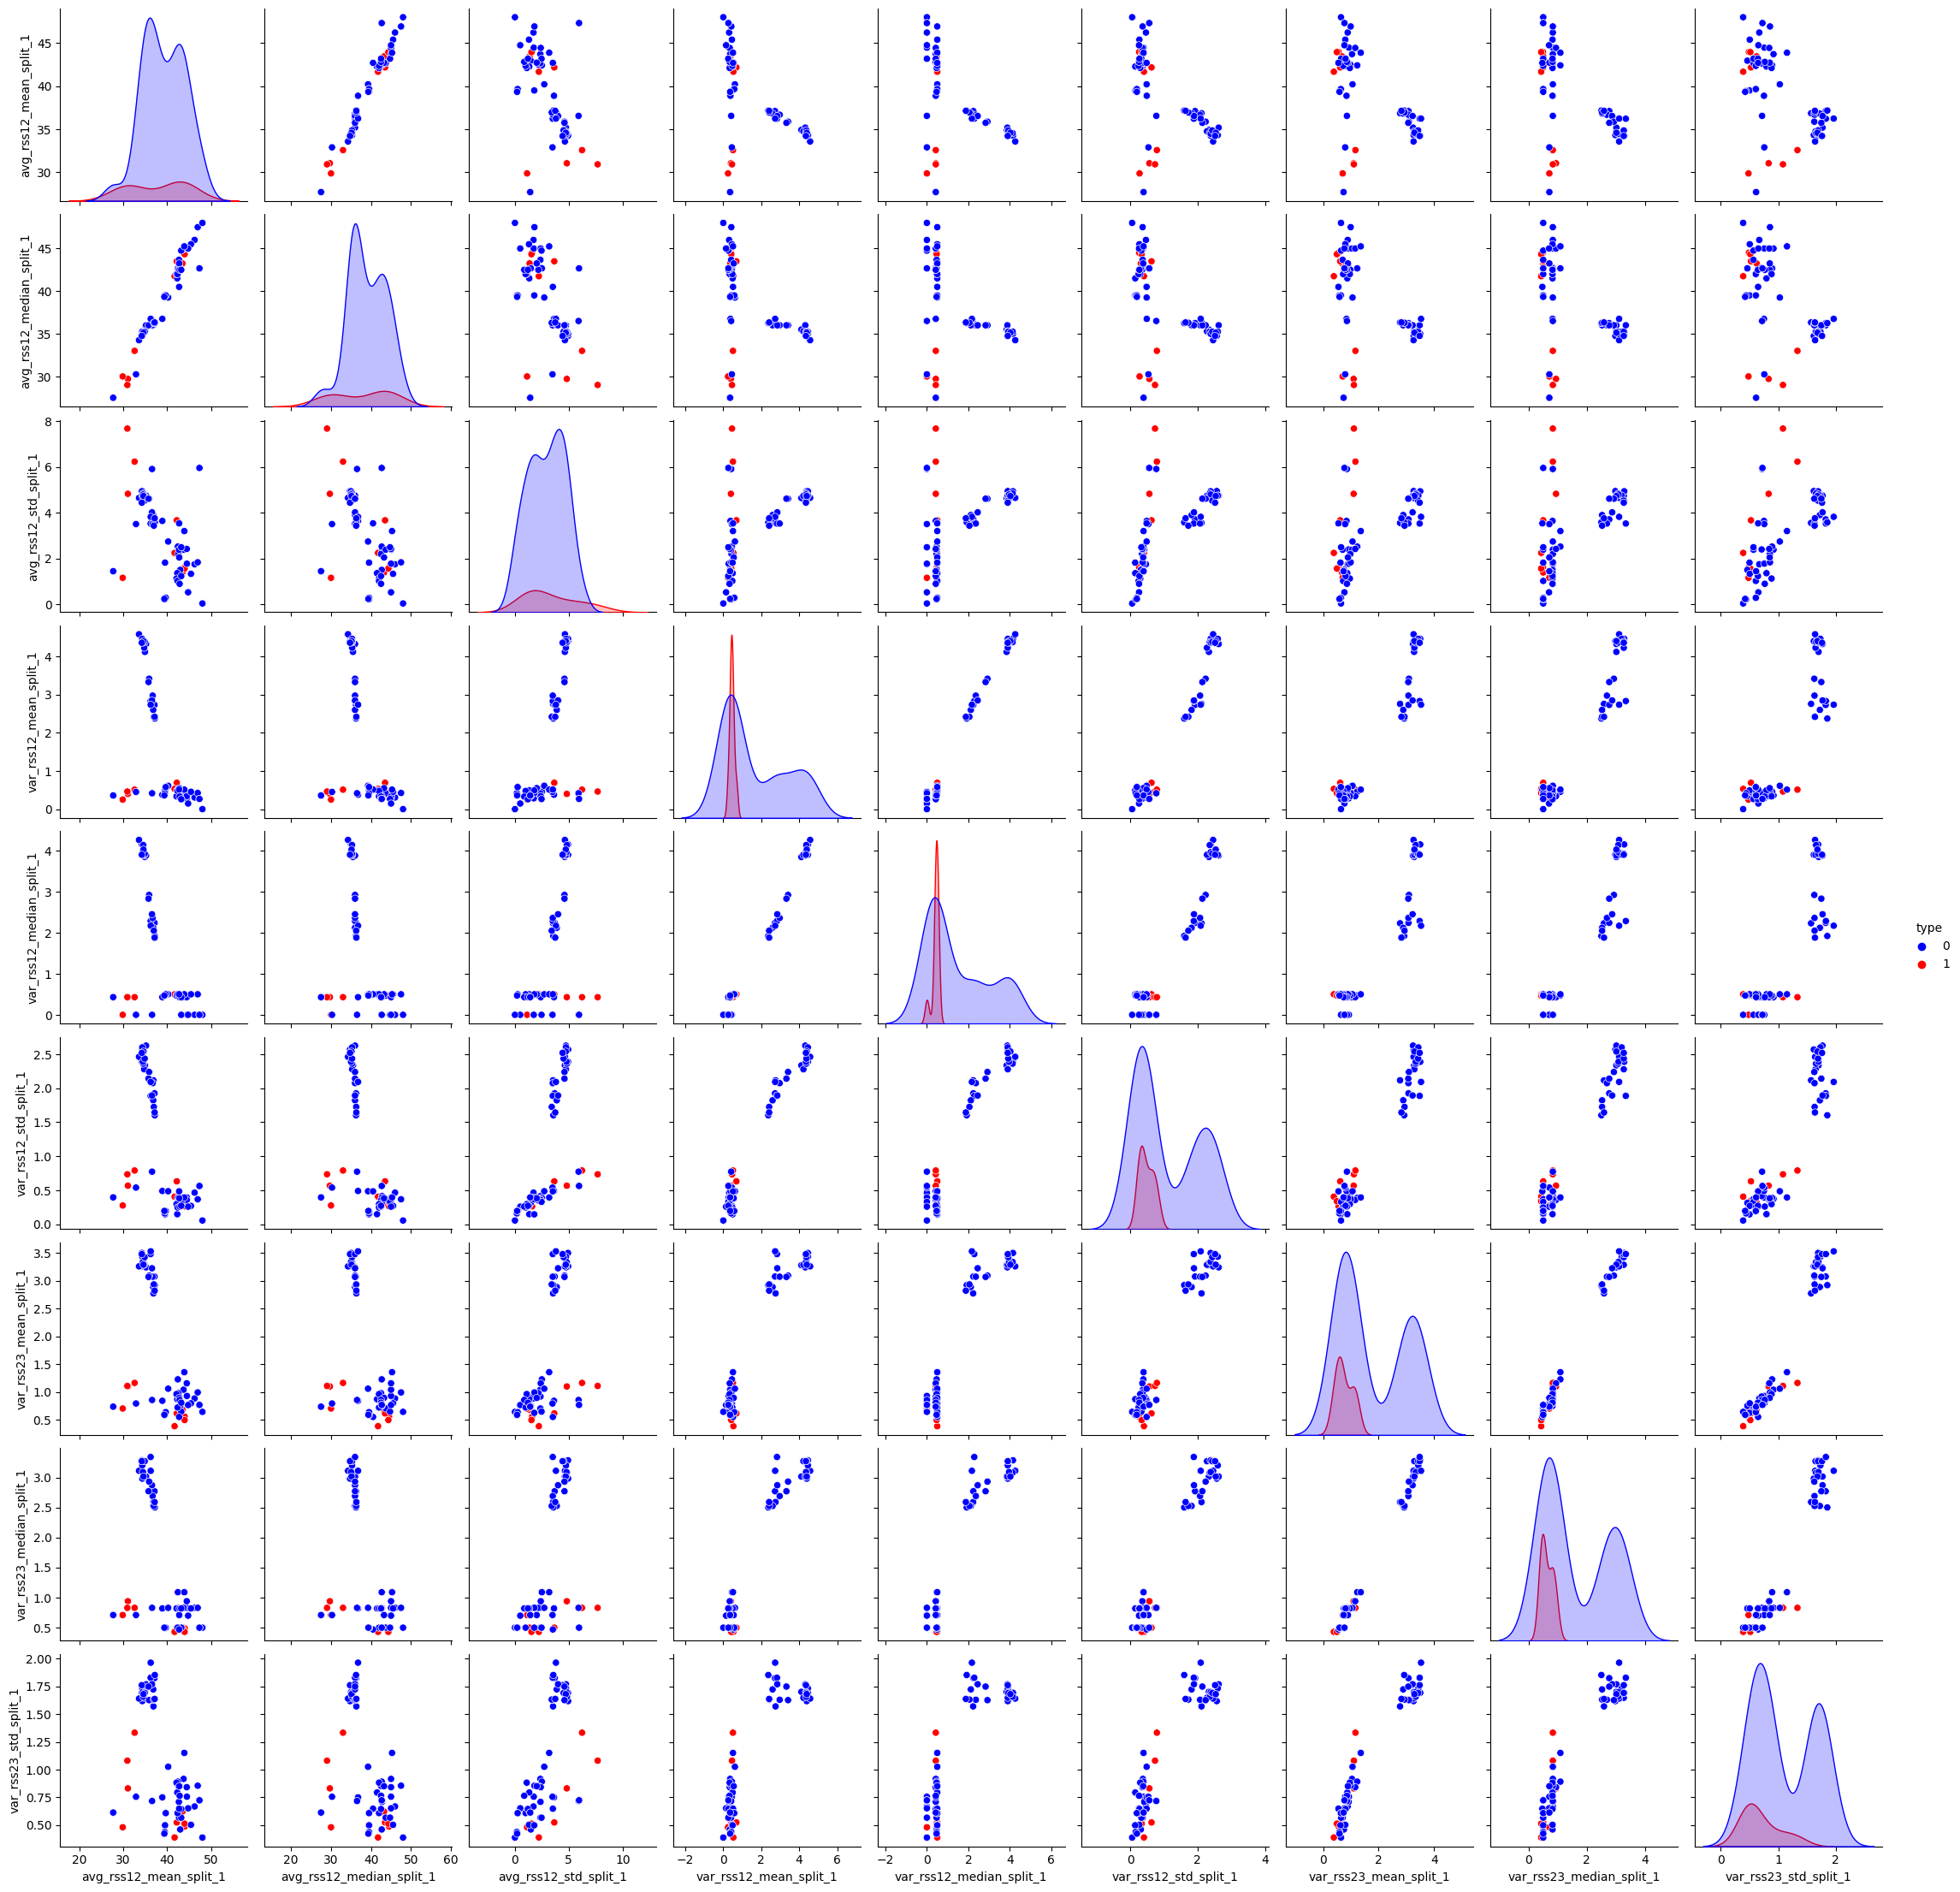

In [23]:
selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']
selected_time_series = ['avg_rss12', 'var_rss12', 'var_rss23']
headers = get_features(selected_time_series, selected_feature_names, 1)      
train_data_1 = get_data(train_data, 1, headers, selected_time_series, selected_features)    
sns.pairplot(data = train_data_1, hue = 'type', palette = {1: 'red', 0: 'blue'})

### ii. Splitted Plots

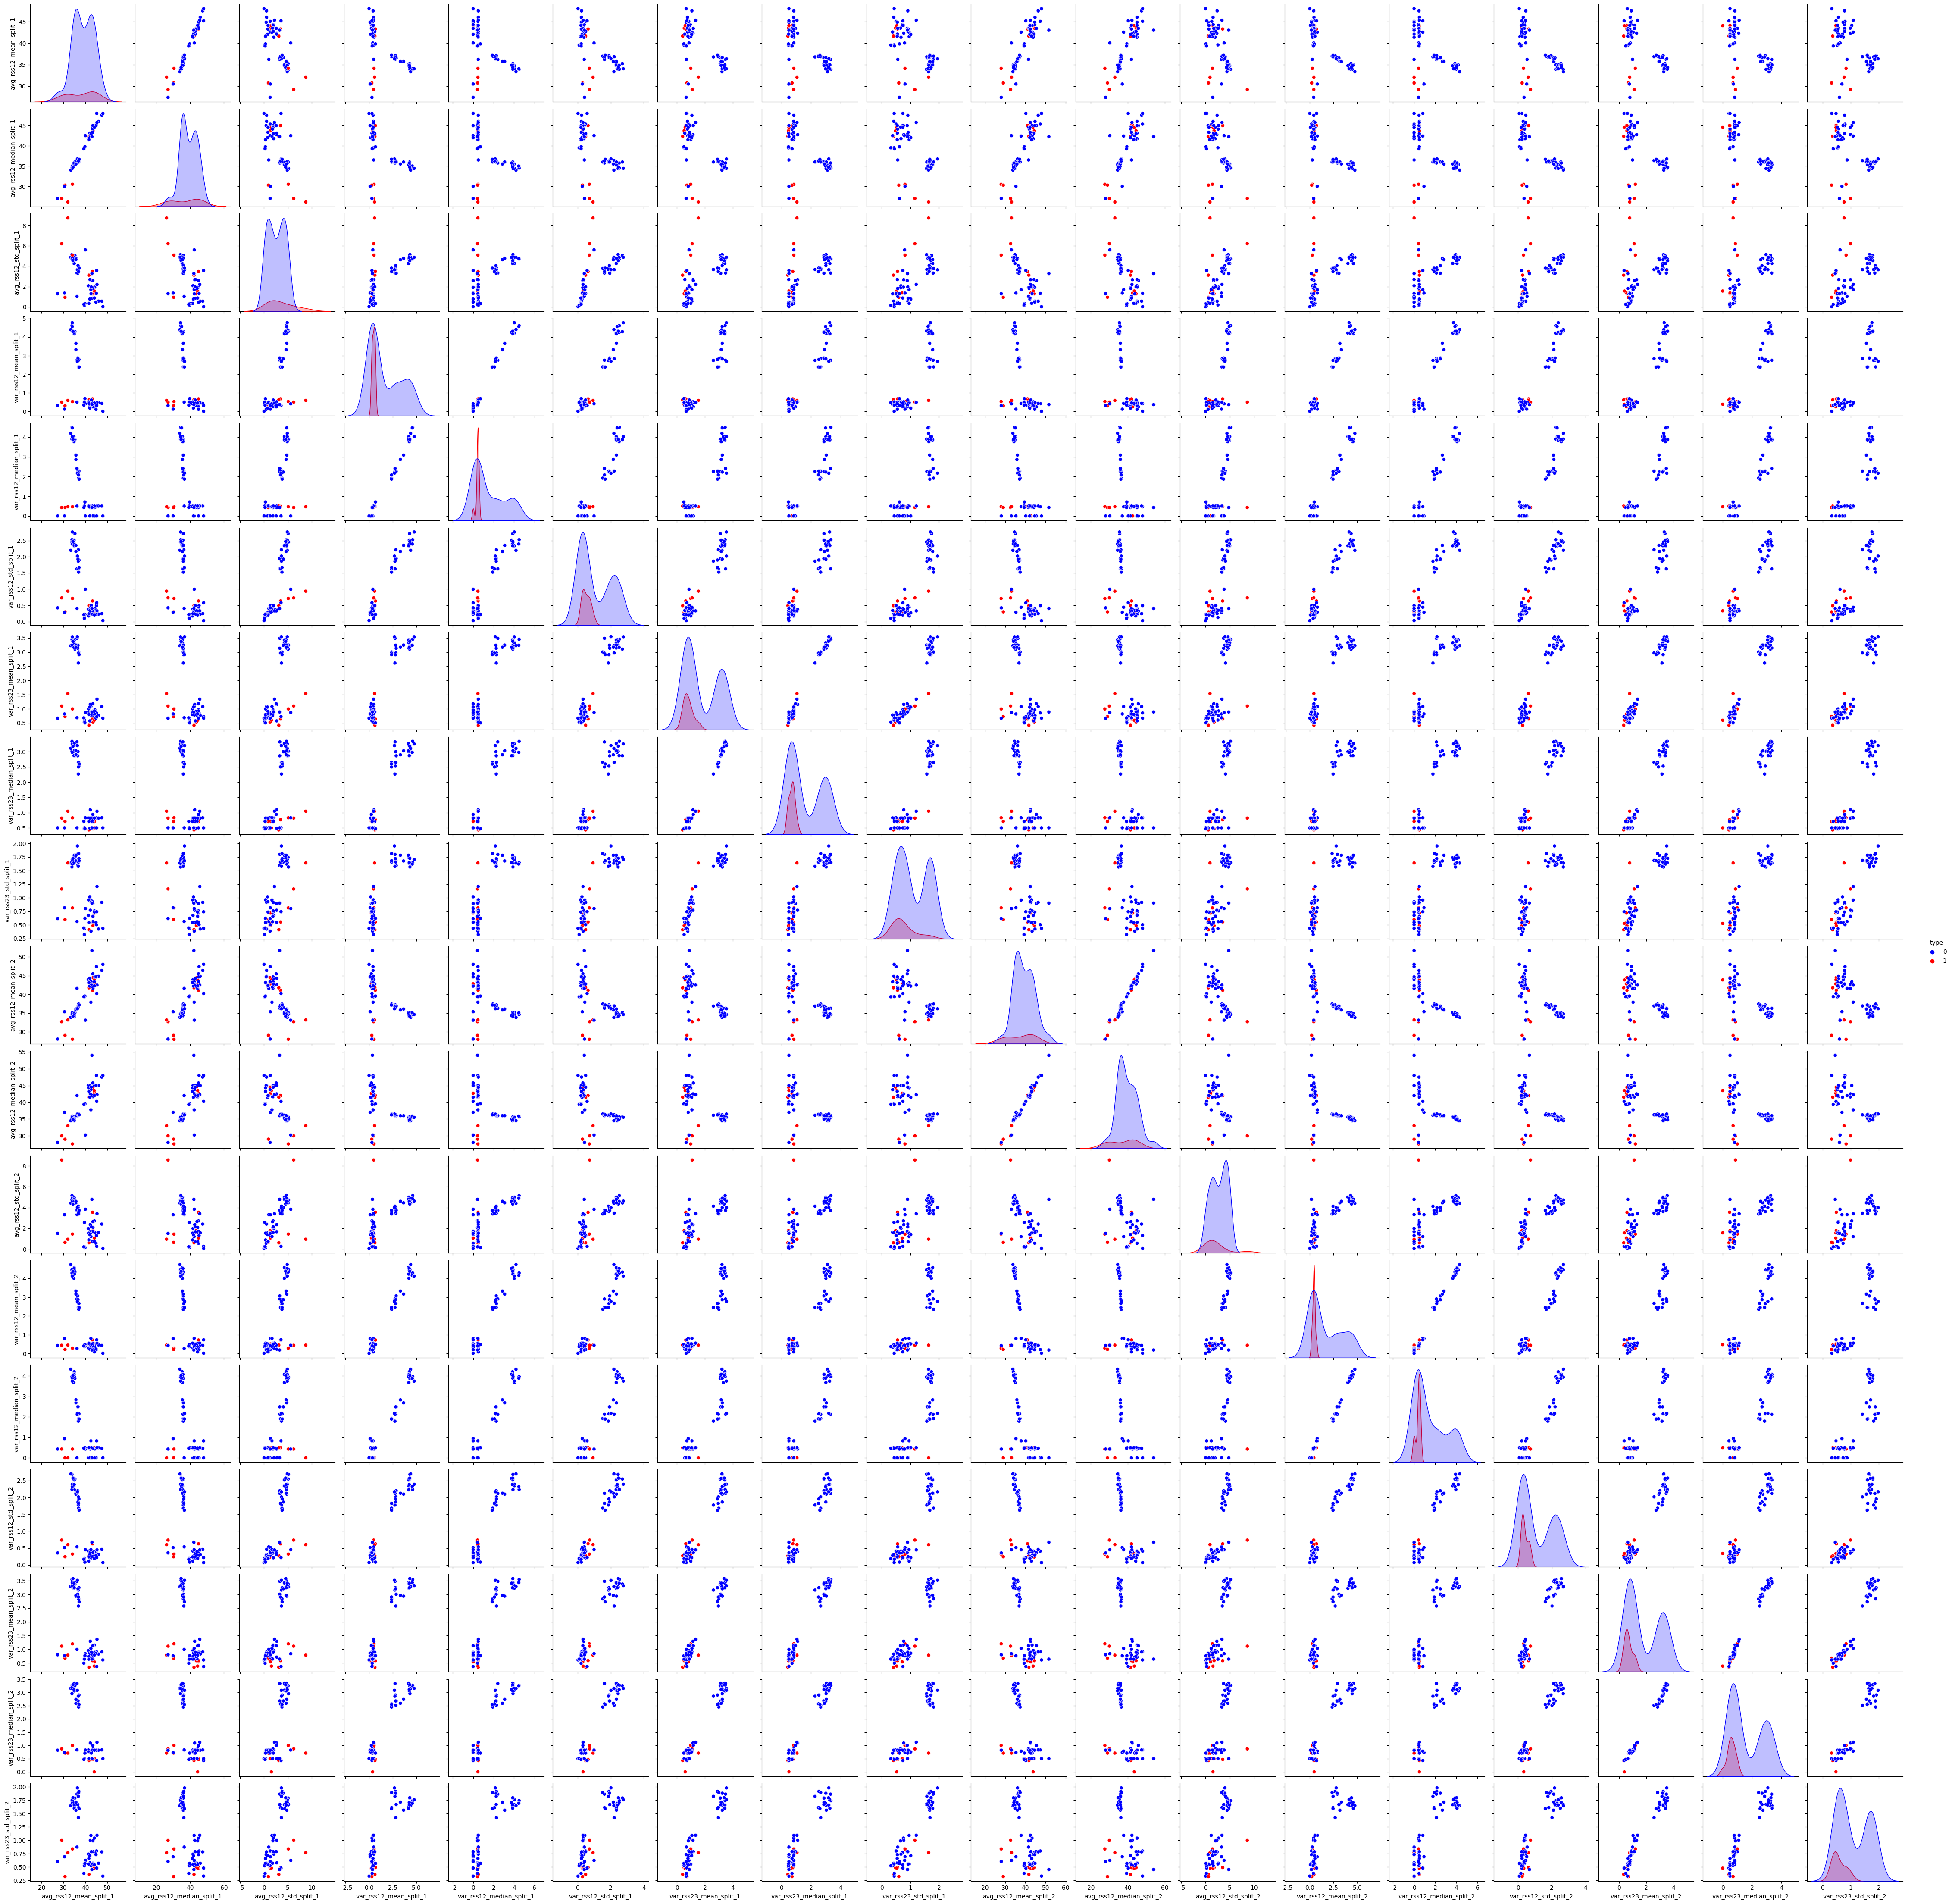

In [24]:
selected_time_series = ['avg_rss12', 'var_rss12', 'var_rss23']
selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']
headers = get_features(selected_time_series, selected_feature_names, 2) 
train_data_1 = get_data(train_data, 2, headers, selected_time_series, selected_features)    
sns.pairplot(data = train_data_1, hue = 'type', palette = {1: 'red', 0: 'blue'})

#### Findings 

After we break each time series into two equal-length time series, both of the results seem to be almost the same on first glance. There is no significant difference between the two.

### iii. Time Series Segments

In [25]:
selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']

In [26]:
# as per the piazza post - https://piazza.com/class/lcplfg0c8cn1ep/post/254 
# using all time series with selected features 

cv_factor, L = 5, 20
result = {'L': [], 'p': [], 'Train Score': [], 'Train Error': []}
for l in range(1, L + 1):
    print("Running logistic regression for l = {}".format(l), end = '\r')
    model, selector, score, error = logistic_regression(train_data, test_data, l, cv_factor, columns, 
                                                 selected_feature_names, selected_features)
    result['L'].append(l)
    result['p'].append(selector.n_features_)
    result['Train Score'].append(score)
    result['Train Error'].append(error)

result = pd.DataFrame(result)
result

,L,p,Train Score,Train Error
0,1,11,0.95714,0.04286
1,2,35,0.94286,0.05714
2,3,4,0.95714,0.04286
3,4,3,0.97143,0.02857
4,5,2,0.97143,0.02857
5,6,4,0.97143,0.02857
6,7,8,0.98571,0.01429
7,8,3,0.97143,0.02857
8,9,57,0.97143,0.02857
9,10,92,0.98571,0.01429


#### Findings:
* We can clearly observe from the above table that best (l, p) pair is (7, 8). I have selected mean, median and std features to do my analysis. 
* The purpose of cross-validation is to estimate the error on test data. We do not want to deprive our algorithm with the knowledge of the various predictors available at the disposal of our dataset. **Hence, the correct way would be to do the Recursive Feature Elimination (RFE) along with Cross Validation.** The other way round, i.e. **RFE before performing Cross Validation is the wrong way.**

### iv. Final logistic regression model and its confusion matrix, ROC and AUC

In [28]:
idx = result['Train Score'].argmax()
best_l = result['L'][idx]
print("Best pair: ({}, {})\n".format(best_l, result['p'][idx]))
l, cv_factor = result['Train Score'].argmax() + 1, 5
features = get_features(columns, selected_feature_names, l)
model, selector, score, error = logistic_regression(train_data, test_data, l, cv_factor, columns, 
                                                 selected_feature_names, selected_features)

RFE_selected_features = selected_features_from_logistic_regression(features[:-1], selector)
print("RFE selected features: ", RFE_selected_features)

Best pair: (7, 8)

RFE selected features:  ['avg_rss23_mean_split_1', 'avg_rss13_mean_split_2', 'avg_rss23_mean_split_2', 'avg_rss23_median_split_2', 'var_rss23_mean_split_3', 'avg_rss12_mean_split_5', 'avg_rss12_median_split_5', 'var_rss13_mean_split_5']


In [29]:
# p value analysis using stat model
features = get_features(columns, selected_feature_names, l)
train_df = get_data(train_data, l, features, columns, selected_features)  
trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
df_temp = trainX.loc[:, RFE_selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype = float))
model2 = sm.Logit(trainY.to_numpy(dtype = float), const_val)
summary = model2.fit(method = 'bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       60
Method:                           MLE   Df Model:                            8
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                   1.000
Time:                        23:30:42   Log-Likelihood:            -1.6375e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 8.882e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6875   1.24e+07  -5.5

#### Findings: 
* As per the above p-value analysis and note underneath, we can say that the data is completely seperated. 
* This error is generally observed with logistic regression when data is seperated and hence p-value estimates can't be reliable

Accuracy: 1.0
Confusion Matrix
[[60  0]
 [ 0  9]]


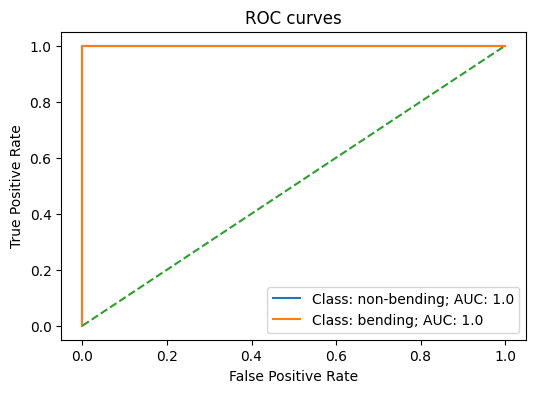

In [30]:
get_cm_roc_plot(model, trainX, trainY, RFE_selected_features)

### v. Test Classifier

In [31]:
selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']

features = get_features(columns, selected_feature_names, best_l)
test_df = get_data(test_data, l, features, columns, selected_features)    

testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
testX

,avg_rss12_mean_split_1,avg_rss12_median_split_1,avg_rss12_std_split_1,var_rss12_mean_split_1,var_rss12_median_split_1,var_rss12_std_split_1,avg_rss13_mean_split_1,avg_rss13_median_split_1,avg_rss13_std_split_1,var_rss13_mean_split_1,...,avg_rss13_std_split_7,var_rss13_mean_split_7,var_rss13_median_split_7,var_rss13_std_split_7,avg_rss23_mean_split_7,avg_rss23_median_split_7,avg_rss23_std_split_7,var_rss23_mean_split_7,var_rss23_median_split_7,var_rss23_std_split_7
0,40.790000,41.00,0.940505,0.498841,0.50,0.200408,18.404638,18.00,3.777019,0.628261,...,3.045451,0.632059,0.470,0.581541,31.150588,30.250,2.073320,0.373676,0.430,0.431443
1,43.423913,43.50,0.343007,0.558261,0.50,0.141608,19.941884,20.50,4.030503,1.178406,...,6.035177,1.545882,1.105,1.389809,32.347059,32.125,1.426052,0.337206,0.430,0.378173
2,34.803768,36.00,4.740425,3.708986,3.54,2.264594,15.778841,16.00,3.195438,3.070000,...,2.842067,3.377794,2.800,1.787811,16.166029,16.375,3.212309,3.742647,3.540,1.842386
3,34.110580,35.00,4.765596,4.415217,3.70,2.603700,15.826812,16.00,3.049908,3.167826,...,2.754766,3.787647,3.705,1.685548,16.176912,16.375,2.885057,3.482500,3.365,1.665705
4,33.191739,33.75,4.449958,4.856812,4.74,2.307347,15.230580,15.50,3.007438,3.195797,...,2.627385,3.500147,3.415,1.758804,16.890735,16.750,3.148417,3.312647,3.060,1.796294
5,21.155797,21.33,2.762022,0.951594,0.71,1.037515,21.759130,22.00,2.202102,0.576377,...,2.416893,0.505588,0.470,0.576550,21.096471,21.000,1.331144,0.641765,0.500,0.343902
6,28.449130,27.33,1.466543,0.085507,0.00,0.196368,19.032029,19.50,3.342897,0.963043,...,4.333218,1.106912,0.830,1.087553,22.212941,22.625,6.284165,1.908235,1.410,1.509044
7,46.458841,46.50,0.525566,0.451884,0.50,0.203501,12.756377,12.00,2.863232,0.870725,...,2.150435,0.642353,0.470,0.756875,12.133382,14.750,4.402874,0.905147,0.830,0.601641
8,42.838986,43.25,1.481226,0.539130,0.50,0.310927,14.916522,15.25,2.120527,0.511304,...,2.416230,0.690441,0.500,0.686537,15.849412,16.250,1.870543,0.795735,0.870,0.423533
9,43.967536,44.67,1.845600,0.440290,0.43,0.368231,12.027681,13.75,4.436539,0.799130,...,3.103708,0.685735,0.450,0.873513,15.540294,16.125,3.270275,1.008824,0.830,0.832304


Accuracy: 1.0
Confusion Matrix
[[15  0]
 [ 0  4]]


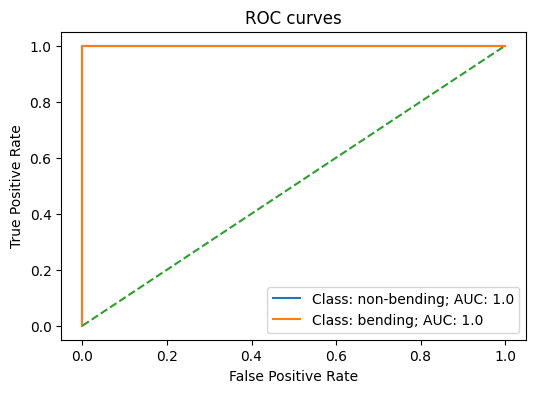

In [32]:
get_cm_roc_plot(model, testX, testY, RFE_selected_features, toggle = True)

#### Findings
* The same test & train accuracy is observed

### vi. Separation

* From the p-value analysis using statmodel suggests that there is complete separation. In this case, the Maximum Likelihood Estimator (MLE) doesn't exist and the parameters are not identified.
* Because of this, it is possible that the well-separation of the classes is cauisng the instability in calculation o fthe regression parameters.

### vii. Imbalance

* Yes, the data has an imbalance in it. **Class 0, i.e. non-bending points are 60. Whereas bending datapoints or true class is just 9. This means that data has imbalance.** 

In [33]:
selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']
cv_factor, L = 5, 20
result = {'L': [], 'p': [], 'Train Score': [], 'Train Error': []}
for l in range(1, L + 1):
    print('Running logistic regression with balanced for l = {}'. format(l), end = '\r')
    model, selector, score, error = logistic_regression(train_data, test_data, l, cv_factor, columns,
                                                 selected_feature_names, selected_features, oversampling = True)
    result['L'].append(l)
    result['p'].append(selector.n_features_)
    result['Train Score'].append(score)
    result['Train Error'].append(error)

result = pd.DataFrame(result)
result

,L,p,Train Score,Train Error
0,1,11,0.97500,0.02500
1,2,14,0.97500,0.02500
2,3,6,0.98333,0.01667
3,4,3,0.98333,0.01667
4,5,6,0.98333,0.01667
5,6,2,0.99167,0.00833
6,7,6,0.98333,0.01667
7,8,10,0.98333,0.01667
8,9,3,1.00000,0.00000
9,10,5,0.99167,0.00833


In [34]:
idx = result['Train Score'].argmax()
best_l, max_train_accuracy, fold_count = result['L'][idx], result['Train Score'][idx], 5
print("Best model with l = {}, max_train_accuracy = {}\n".format(best_l, max_train_accuracy))
features = get_features(columns, selected_feature_names, best_l)
model, selector, score, error = logistic_regression(train_data, test_data, best_l, cv_factor, columns,
                                                 selected_feature_names, selected_features, oversampling = True)

RFE_selected_features = selected_features_from_logistic_regression(features[:-1], selector)
print("Selected features: ", RFE_selected_features)

Best model with l = 9, max_train_accuracy = 1.0

Selected features:  ['avg_rss23_median_split_2', 'avg_rss23_mean_split_3', 'avg_rss12_mean_split_6']


ROC Curve for train data
Accuracy: 1.0
Confusion Matrix
[[60  0]
 [ 0 60]]


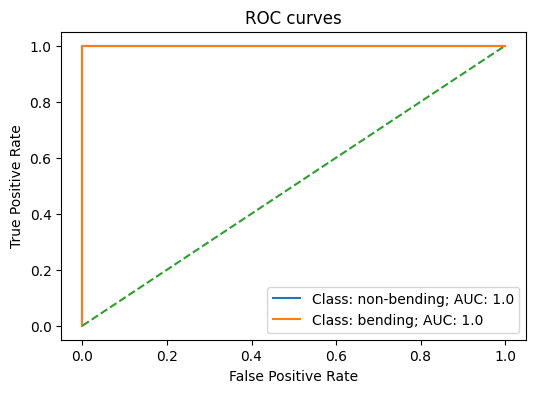

ROC Curve for test data
Accuracy: 1.0
Confusion Matrix
[[15  0]
 [ 0  4]]


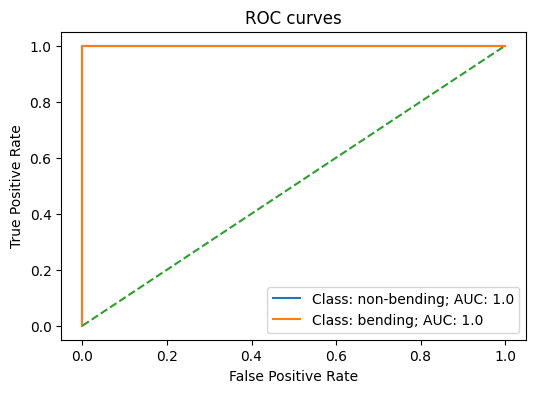

In [35]:
features = get_features(columns, selected_feature_names, best_l)
train_df = get_data(train_data, best_l, features, columns, selected_features)    
train_df = oversample_imbalance_class(train_df)
trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
print("ROC Curve for train data")
get_cm_roc_plot(model, trainX, trainY, RFE_selected_features)
print("ROC Curve for test data")
get_cm_roc_plot(model, testX, testY, RFE_selected_features)

## (b) Binary Classification Using L1-penalized logistic regression

### i. Time Series Segments

In [36]:
def getIndex(model, find_C_in_dict):
    for i, c in enumerate(model.Cs_):
        if (c == find_C_in_dict): 
            return i

# utility  method for performing regression based on the given classifier
def perform_classification(train_data, test_data, l, columns, selected_feature_name, selected_feature, 
                         cv_factor = None, is_plot_roc = False,
                         is_binary = False, is_gaussian = False, is_multinomial_prior = False):
    
    features = get_features(columns, selected_feature_name, l)
    test_df = get_data(test_data, l, features, columns, selected_feature, is_binary = is_binary)  
    train_df = get_data(train_data, l, features, columns, selected_feature, is_binary = is_binary)
        
    # splitting labels from training data
    trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    random_state = 69 if cv_factor != None else None
    
    # main model for binary and multinomial
    if is_binary:
        model = LogisticRegressionCV(penalty = 'l1', max_iter = 100, scoring = 'accuracy',
                                     cv = cv_factor, random_state = random_state, solver = 'liblinear')  
        model.fit(trainX, trainY)
        idx = getIndex(model, model.C_[0])
        train_score = np.mean(model.scores_[1][:, idx])
    elif is_gaussian:
        model = GaussianNB()
        if (is_plot_roc):
            model.fit(trainX, trainY)
        score = cross_val_score(estimator = model,X = trainX, y = trainY, 
                                cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True), 
                                scoring = "accuracy")
        train_score = np.mean(score)
    elif is_multinomial_prior:
        model = MultinomialNB()
        if (is_plot_roc):
            model.fit(trainX, trainY)
        score = cross_val_score(estimator = model,X = trainX, y = trainY, 
                                cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True), 
                                scoring = "accuracy")
        train_score = np.mean(score)
        
    else:
        model = LogisticRegressionCV(penalty = 'l1', max_iter = 100, multi_class = 'multinomial', 
                                     cv = cv_factor, random_state = random_state, solver = 'saga') 
        model.fit(trainX, trainY)
        idx = getIndex(model, model.C_[0])
        score = 0
        for class_ in model.scores_.keys():
            score += np.mean(model.scores_[class_][:, idx])
        train_score = score/len(model.scores_.keys())
    train_error = round((1 - train_score), 4)
    
    
    # printing results as per the need
    if not is_plot_roc:    
        return [l, train_score, train_error]
    else:
        
        train_predict = model.predict_proba(trainX)
        test_predict = model.predict_proba(testX)
        pred_y = model.predict(testX)
        cm = confusion_matrix(testY, pred_y)
        
        print("Confusion matrix for test data:\n{}".format(cm))
        print("\nROC Curve for Train Data")
        plot_roc(trainY, train_predict, model)
        
        print("\nROC Curve for Test Data")
        plot_roc(testY, test_predict, model)

In [37]:
# making use of the varargs concept
cv_factor, total_l, result = 5, 20, []
selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']

global max_train_accuracy, best_l
max_train_accuracy, best_l = 0, 1

# performing regression for l = 1 to 20
for l in range(1, total_l + 1):
    
    print("Running binary logistic regression with l = {}".format(l), end = '\r')
    result.append(perform_classification(train_data, test_data, l, columns, selected_feature_names, 
                                     selected_features, cv_factor = cv_factor, is_binary = True))
    if result[-1][1] > max_train_accuracy:
        max_train_accuracy = result[-1][1]
        best_l = l

result = pd.DataFrame(result, columns = ['L', 'Train Score', 'Train Error'])
result

,L,Train Score,Train Error
0,1,0.942857,0.0571
1,2,0.942857,0.0571
2,3,0.928571,0.0714
3,4,0.928571,0.0714
4,5,0.928571,0.0714
5,6,0.942857,0.0571
6,7,0.928571,0.0714
7,8,0.928571,0.0714
8,9,0.942857,0.0571
9,10,0.942857,0.0571


Best model with l = 20, max_train_accuracy = 0.9714285714285715

Performing the analysis on test data with best l = 20

Confusion matrix for test data:
[[15  0]
 [ 1  3]]

ROC Curve for Train Data


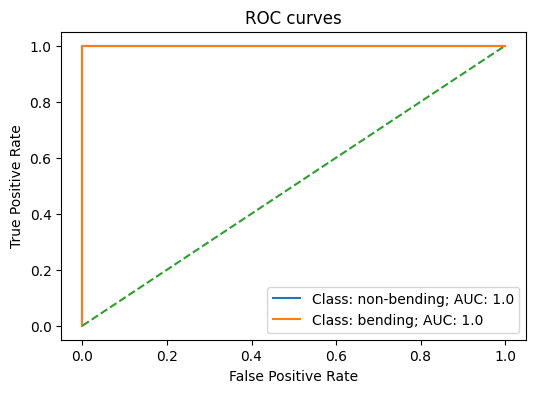


ROC Curve for Test Data


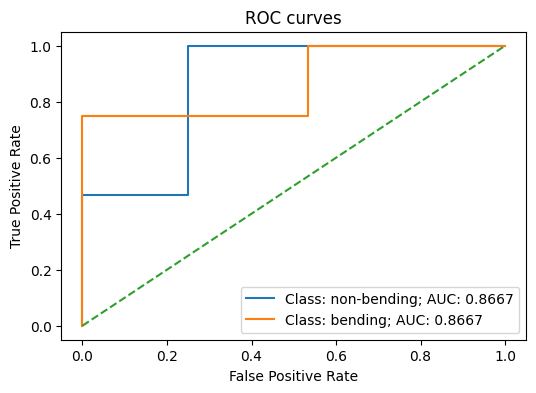

In [38]:
print("Best model with l = {}, max_train_accuracy = {}\n".format(best_l, max_train_accuracy))
print("Performing the analysis on test data with best l = {}\n".format(best_l))
perform_classification(train_data, test_data, best_l, columns, selected_feature_names, selected_features, 
                   is_binary = True, is_plot_roc = True)

### ii. Comparison

* The L1-regularization logistic regression has worse performance when it comes to accuracy on the test data and hence, **the L1-regularization performs worse than RFECV logistic regression. However, the L1-regularization is easier to implement as feature selection does not need to be manual.**

## (c) Multi-class Classification (The Realistic Case)

### i. Time Series Segments

In [39]:
# making use of the varargs concept
cv_factor, max_train_accuracy, best_l, total_l, result = 5, 0, 1, 20, []

selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']

global max_train_accuracy, best_l
max_train_accuracy, best_l = 0, 1
# performing regression for l = 1 to 20
for l in range(1, total_l + 1):
    
    print("Running multiclass classification with l = {}".format(l), end = '\r')
    result.append(perform_classification(train_data, test_data, l, columns, selected_feature_names,
                                       selected_features, cv_factor = cv_factor))
    if result[-1][1] > max_train_accuracy:
        max_train_accuracy = result[-1][1]
        best_l = l

result = pd.DataFrame(result, columns = ['L', 'Train Score', 'Train Error'])
result

,L,Train Score,Train Error
0,1,0.871429,0.1286
1,2,0.871429,0.1286
2,3,0.827473,0.1725
3,4,0.812088,0.1879
4,5,0.754945,0.2451
5,6,0.754945,0.2451
6,7,0.754945,0.2451
7,8,0.710989,0.2890
8,9,0.739560,0.2604
9,10,0.725275,0.2747


Best model with l = 1, max_train_accuracy = 0.8714285714285717

Performing the analysis on test data with best l = 1

Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]

ROC Curve for Train Data


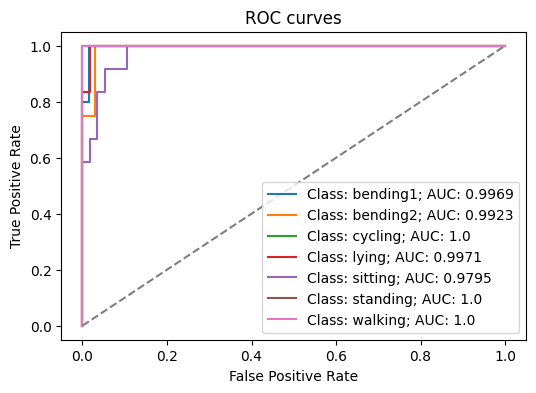


ROC Curve for Test Data


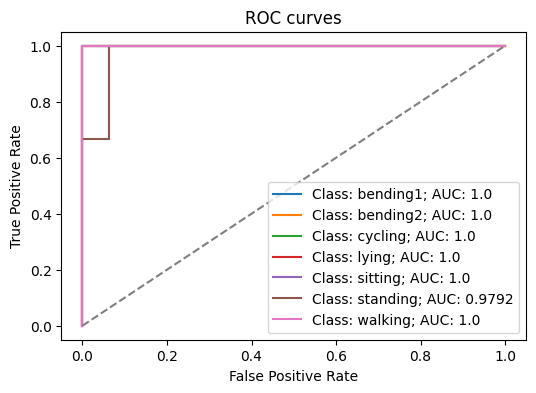

In [40]:
print("Best model with l = {}, max_train_accuracy = {}\n".format(best_l, max_train_accuracy))
print("Performing the analysis on test data with best l = {}\n".format(best_l))
perform_classification(train_data, test_data, best_l, columns, selected_feature_names, 
                     selected_features, is_plot_roc = True)

### ii. Naive Bayes

#### Gaussian

In [41]:
# making use of the varargs concept
total_l, result = 20, []

selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']

global max_train_accuracy, best_l
max_train_accuracy, best_l = 0, 1

# performing regression for l = 1 to 20
for l in range(1, total_l + 1):
    
    print("Running Gaussian - naive bayes' classification with l = {}".format(l), end = '\r')
    result.append(perform_classification(train_data, test_data, l, columns, selected_feature_names,
                                       selected_features, is_gaussian = True))
    if result[-1][1] > max_train_accuracy:
        max_train_accuracy = result[-1][1]
        best_l = l

result = pd.DataFrame(result, columns = ['L', 'Train Score', 'Train Error'])
result

,L,Train Score,Train Error
0,1,0.870330,0.1297
1,2,0.797802,0.2022
2,3,0.768132,0.2319
3,4,0.770330,0.2297
4,5,0.753846,0.2462
5,6,0.681319,0.3187
6,7,0.710989,0.2890
7,8,0.724176,0.2758
8,9,0.709890,0.2901
9,10,0.767033,0.2330


Best model with l = 1, max_train_accuracy = 0.8703296703296705

Performing the analysis on test data with best l = 1

Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]

ROC Curve for Train Data


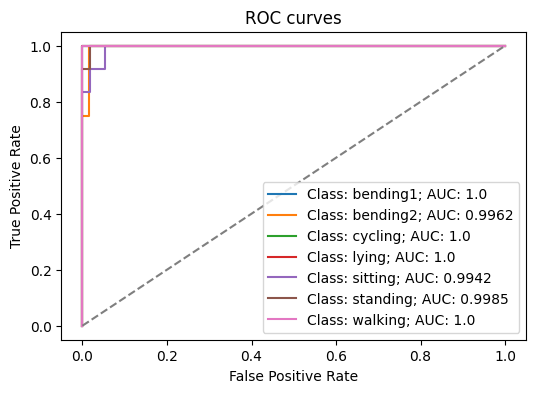


ROC Curve for Test Data


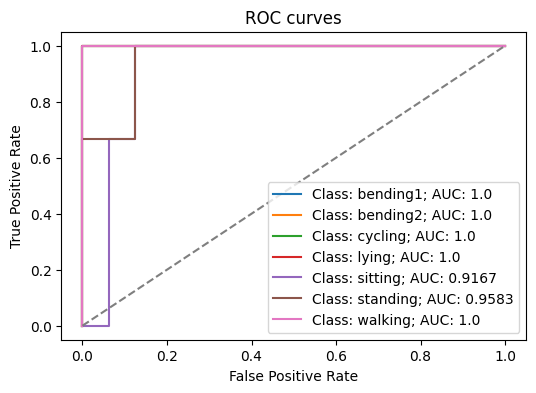

In [42]:
print("Best model with l = {}, max_train_accuracy = {}\n".format(best_l, max_train_accuracy))
print("Performing the analysis on test data with best l = {}\n".format(best_l))
perform_classification(train_data, test_data, best_l, columns, selected_feature_names, 
                     selected_features, is_gaussian = True, is_plot_roc = True)

#### Multi-nomial priors

In [43]:
# making use of the varargs concept
cv_factor, max_train_accuracy, best_l, total_l, result = 5, 0, 1, 20, []

selected_feature_names = ['mean', 'median', 'std']
selected_features = ['mean', '50%', 'std']

global max_train_accuracy, best_l
max_train_accuracy, best_l = 0, 1

# performing regression for l = 1 to 20
for l in range(1, total_l + 1):
    
    print("Running Multinomial priors - Naive Bayes' regression with l = {}".format(l), end = '\r')
    result.append(perform_classification(train_data, test_data, l, columns, selected_feature_names,
                                       selected_features, is_multinomial_prior = True))
    if result[-1][1] > max_train_accuracy:
        max_train_accuracy = result[-1][1]
        best_l = l

result = pd.DataFrame(result, columns = ['L', 'Train Score', 'Train Error'])
result

,L,Train Score,Train Error
0,1,0.825275,0.1747
1,2,0.826374,0.1736
2,3,0.812088,0.1879
3,4,0.827473,0.1725
4,5,0.840659,0.1593
5,6,0.797802,0.2022
6,7,0.783516,0.2165
7,8,0.783516,0.2165
8,9,0.769231,0.2308
9,10,0.769231,0.2308


Best model with l = 5, max_train_accuracy = 0.8406593406593406

Performing the analysis on test data with best l = 5

Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]

ROC Curve for Train Data


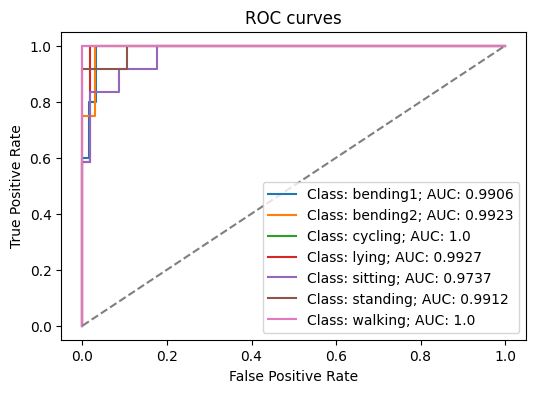


ROC Curve for Test Data


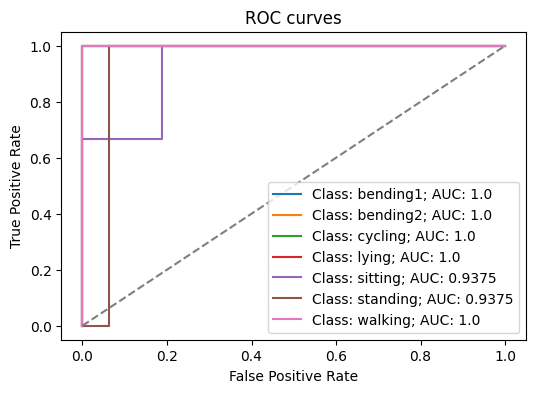

In [44]:
print("Best model with l = {}, max_train_accuracy = {}\n".format(best_l, max_train_accuracy))
print("Performing the analysis on test data with best l = {}\n".format(best_l))
perform_classification(train_data, test_data, best_l, columns, selected_feature_names, 
                   selected_features, is_multinomial_prior = True, is_plot_roc = True)

### Findings

**Looking at the values the accuracy for both the methods, we can say that the Gaussian method is working better than Multinomial.**

### iii. Comparision

**The area under the ROC curve (AUC) is relatively better for the Logistic Regression curve than any other classifer prior (Gaussian or Multinomial) and hence, I would say that Logistic Regression has better classification for the given dataset**

## 3. ISLR 4.8.3

We can write posterior probability of the k-th class:
$$p_k(x) = \frac {\pi_k \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2) } {\sum { \pi_l \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_l)^2) }}$$

The independet term w.r.t k in the above equation is:
$$C' = \frac { \frac {1} {\sqrt{2 \pi}}} {\sum { \pi_l \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_l)^2) }}$$

Hence, 
$$p_k(x) = C' \frac{\pi_k}{\sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2)$$
  
Taking log of both sides
$$log(p_k(x)) = log(C') + log(\pi_k) - log(\sigma_k) + (- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2)$$
  
$$log(p_k(x)) = (- \frac {1} {2 \sigma_k^2} (x^2 + \mu_k^2 - 2x\mu_k)) + log(\pi_k) - log(\sigma_k) + log(C')$$
  
Notice the first term and it is a quadratic function of x. So Bayes’s classfier not linear.

## 4. ISLR 4.8.7

There are two classes of response value. Here we can use Bayes’ therorem:

$$Pr(Y=Yes|X=x)=\frac{\pi_1 f_1(x)}{\sum_{l=1}^2\pi_l f_l(x)}$$

where $f_i(x) = \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{\frac{-1}{2\sigma_i^2}(x - \mu_i)^2}$ 

Here $\pi_1 = 0.8, \pi_2 = 0.2$, $f_1(x)$ is the density function of a normal random variable with mean $10$ and variance $36$ and $f_2(x)$ is the density function of a normal random variable with mean $0$ and variance $36$.

Pluggin all values to the above equation: 

$$Pr(Y=Yes|X=x) = \frac{0.8e^{\frac{-1}{2*36}(4 - 10)^2}}{0.8e^{\frac{-1}{2*36}(4 - 10)^2} + 0.2e^{\frac{-1}{2*36}(4 - 0)^2}}$$

$$Pr(Y=Yes|X=x) = 0.7519$$
